In [57]:
#문제 정의: 아파트 분양 세대수 분석해서 전국에서 분양하는 아파트의 세대가 어떻게 진행될지 분석해본다. 분양 세대수가 늘어날 것으로 예상된다.
#데이터 선택: 분기별로 전국의 아파트 분양 세대수를 나타낸 표를 보여줘서 분양하는 아파트 세대수를 예측해볼 수 있도록 도움을 준다.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score  # 실루엣 점수 계산을 위해 추가

In [2]:
# 데이터 로드
df = pd.read_csv("주택도시보증공사_민간아파트 분양세대수_20230630.csv", encoding='cp949')

# 데이터 확인
print(df.head())


   시도  2021년1분기  2021년2분기  2021년3분기  2021년4분기  2022년1분기  2022년2분기  2022년3분기  \
0  전국     20344     21693     15172     33221     12163     11114     15696   
1  서울        55        48       593        60       464       148         0   
2  인천       104       153         0      2373      2455      1170       474   
3  경기      3166      8463      6869      6676      5042      2957      4912   
4  부산         0       656         0      2522       725         0         0   

   2022년4분기  2023년1분기  2023년2분기  
0     11304      6833     14436  
1       219       738       986  
2       485       868      1370  
3      3352      1665      4835  
4         0      2384      2382  


In [4]:
# 결측치 처리 및 평균값으로 대체
df.replace(' ', np.nan, inplace=True)  # 공백을 결측치로 변경

# 문자열 값을 포함하지 않는 열을 선택하여 결측치를 평균값으로 대체
numeric_columns = df.select_dtypes(include=np.number).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# 결측치 확인
print("결측치 개수:\n", df.isnull().sum())


결측치 개수:
 시도          0
2021년1분기    0
2021년2분기    0
2021년3분기    0
2021년4분기    0
2022년1분기    0
2022년2분기    0
2022년3분기    0
2022년4분기    0
2023년1분기    0
2023년2분기    0
dtype: int64


In [51]:
# 결측치 처리
df.replace(' ', np.nan, inplace=True)  # 공백을 결측치로 변경
numeric_columns = df.select_dtypes(include=np.number).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# 데이터 정규화
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[numeric_columns])  # 숫자 값을 가지는 열에 대해서만 정규화
df_scaled = pd.DataFrame(scaled_features, columns=df[numeric_columns].columns)

# 정규화된 데이터 확인
print(df_scaled.head())


   2021년1분기  2021년2분기  2021년3분기  2021년4분기  2022년1분기  2022년2분기  2022년3분기  \
0  3.902317  3.795094  3.700797  4.011111  3.748475  3.883919  3.858965   
1 -0.475921 -0.464940 -0.299873 -0.493239 -0.307686 -0.427305 -0.482371   
2 -0.465347 -0.444274 -0.462600 -0.179058  0.382614 -0.025511 -0.351268   
3  0.195413  1.191248  1.422345  0.405431  1.279553  0.677039  0.876233   
4 -0.487790 -0.345277 -0.462600 -0.158819 -0.217195 -0.485490 -0.482371   

   2022년4분기  2023년1분기  2023년2분기  
0  3.888807  3.772931  3.861797  
1 -0.401343 -0.013183 -0.185987  
2 -0.298395  0.067571 -0.070422  
3  0.811200  0.562654  0.972371  
4 -0.486101  1.009285  0.234140  


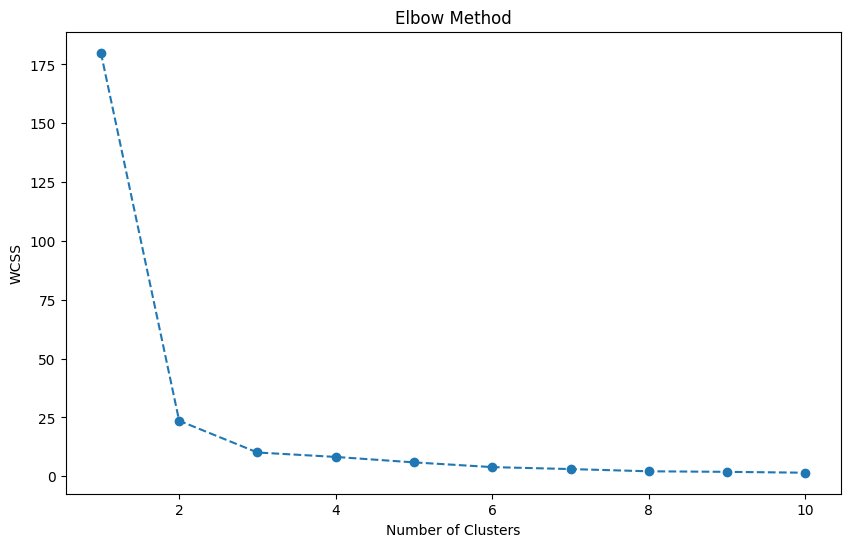

In [52]:
# 엘보우 방법을 사용하여 최적의 클러스터 수 찾기
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# 엘보우 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


In [53]:
# 최적의 클러스터 수 결정
optimal_k = 3

# K-means 알고리즘 초기화 및 클러스터링 수행
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
kmeans.fit(df_scaled)

# 클러스터링 결과 확인
df['Cluster'] = kmeans.labels_
print(df.head())


   시도  2021년1분기  2021년2분기  2021년3분기  2021년4분기  2022년1분기  2022년2분기  2022년3분기  \
0  전국     20344     21693     15172     33221     12163     11114     15696   
1  서울        55        48       593        60       464       148         0   
2  인천       104       153         0      2373      2455      1170       474   
3  경기      3166      8463      6869      6676      5042      2957      4912   
4  부산         0       656         0      2522       725         0         0   

   2022년4분기  2023년1분기  2023년2분기  Cluster  
0     11304      6833     14436        1  
1       219       738       986        0  
2       485       868      1370        0  
3      3352      1665      4835        2  
4         0      2384      2382        0  


In [54]:
# 숫자 값만 있는 열 선택
numeric_columns = df.select_dtypes(include=np.number).columns

# 각 클러스터의 특성 분석
cluster_analysis = df.groupby('Cluster')[numeric_columns].mean()
print(cluster_analysis)


          2021년1분기   2021년2분기    2021년3분기    2021년4분기    2022년1분기    2022년2분기  \
Cluster                                                                         
0         1073.625    826.875    518.9375   1659.0625    445.0625    509.8125   
1        20344.000  21693.000  15172.0000  33221.0000  12163.0000  11114.0000   
2         3166.000   8463.000   6869.0000   6676.0000   5042.0000   2957.0000   

         2022년3분기  2022년4분기  2023년1분기    2023년2분기  Cluster  
Cluster                                                     
0           674.0     497.0     323.0    600.0625      0.0  
1         15696.0   11304.0    6833.0  14436.0000      1.0  
2          4912.0    3352.0    1665.0   4835.0000      2.0  


/home/codespace/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 45380 (\N{HANGUL SYLLABLE NYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codespace/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codespace/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codespace/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codespace/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  fig.canvas.print_fig

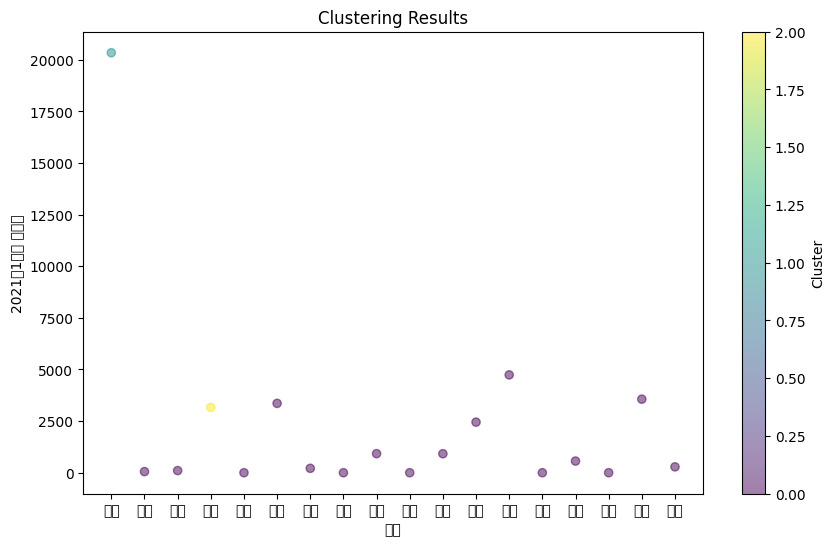

In [55]:
# 클러스터를 시각화하여 각 클러스터가 어떻게 구성되어 있는지 보여주는 산점도 작성
plt.figure(figsize=(10, 6))
plt.scatter(df['시도'], df['2021년1분기'], c=df['Cluster'], cmap='viridis', alpha=0.5)  # clusters 대신 df['Cluster'] 사용
plt.title('Clustering Results')
plt.xlabel('시도')
plt.ylabel('2021년1분기 세대수')
plt.colorbar(label='Cluster')
plt.show()

In [56]:
# 실루엣 점수를 계산하여 클러스터링의 효과를 평가
silhouette_avg = silhouette_score(scaled_features, kmeans.labels_)  # clusters 대신 kmeans.labels_ 사용
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.6345266021259139


In [ ]:
#평가: 실루엣 점수가 1에 가까울수록 클러스터링 결과가 잘 나왔음을 의미하는데 0.6이면 살짝 애매하지만 클러스터링 과정은 적절한것 같습니다.